In [1]:
import pandas as pd
import numpy as np
import time
from numpy import hstack
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import *
from keras.layers.wrappers import *
from tensorflow.keras.optimizers import RMSprop
from keras.callbacks import CSVLogger, EarlyStopping
import tensorflow as tf

from models import *
from plots_lstm import *
from preprocessing_data import *

In [ ]:
# TODO 
# https://www.kaggle.com/nicapotato/keras-timeseries-multi-step-multi-output
# https://github.com/niklascp/bus-arrival-convlstm
# https://machinelearningmastery.com/deep-learning-models-for-multi-output-regression/
#

In [ ]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

In [2]:
df = pd.read_csv("../data/data_processed.csv")
df['date'] = pd.to_datetime(df['date'], format='%Y/%m/%d %H:%M')

df['fve'] = df['fve'] * 0.03
df['mve'] = df['mve'] * 0.07
df['wpg'] = df['wpg'] * 0.07

df['production_usage'] = df['fve'] + df['mve'] + df['wpg'] 
df['production_usage'] = df['production_usage'].fillna(df['production_usage'].median())

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               35040 non-null  datetime64[ns]
 1   shops              35040 non-null  float64       
 2   office_building    35040 non-null  float64       
 3   industrial_park    35040 non-null  float64       
 4   fve                35036 non-null  float64       
 5   mve                35036 non-null  float64       
 6   wpg                35036 non-null  float64       
 7   price              35040 non-null  float64       
 8   isWeekend          35040 non-null  int64         
 9   isHoliday          35040 non-null  int64         
 10  production_usage   35040 non-null  float64       
 11  consumption_usage  35040 non-null  float64       
 12  temp               35040 non-null  float64       
 13  wind               35040 non-null  int64         
 14  hour  

In [4]:
features =  [
                    'consumption_usage','price', 'isWeekend', 
                    'isHoliday',  'temp', 'wind','day_cos', 'day_sin',
                    'month_cos', 'month_sin'
                    ]
past_history = 192 # 2days
future_target = 16 # 4hours
STEP = 1
TRAIN_SPLIT = 18000
BUFFER_SIZE = 2000
BATCH_SIZE = 64
EPOCHS = 100
EVALUATION_INTERVAL = 10
train_data, val_data, x_train, y_train = preprocess_data_for_LSTM(
    df[:20000], 
    features, 
    past_history,
    future_target,
    STEP,
    TRAIN_SPLIT,
    BATCH_SIZE,
    BUFFER_SIZE)

(17808, 192, 10)
(17808, 16)
Single window of past history : (192, 10)
Target usage to predict : (16,)


In [5]:
pastHistory_range = x_train.shape[-2:][0]
number_of_features = x_train.shape[-2:][1]
model = build_model_BasicLSTM(pastHistory_range,number_of_features,future_target)

early_stopping = EarlyStopping(monitor='val_loss', patience = 3, restore_best_weights=True)
history = model.fit(
                                train_data,
                                epochs=EPOCHS,
                                steps_per_epoch=EVALUATION_INTERVAL,
                                validation_data=val_data,
                                validation_steps=EVALUATION_INTERVAL,
                                callbacks=[early_stopping]
                                )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 192, 32)           5504      
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense (Dense)                (None, 16)                272       
Total params: 8,912
Trainable params: 8,912
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
10/10 [==============================] - 4s 196ms/step - loss: 1.0084 - val_loss: 0.7882
Epoch 2/100
10/10 [==============================] - 1s 131ms/step - loss: 0.8483 - val_loss: 0.7687
Epoch 3/100
10/10 [==============================] - 1s 143ms/step - loss: 0.7451 - val_loss: 0.7538
Epoch 4/100
10/10 [==============================] - 1s 132ms/step - loss: 0

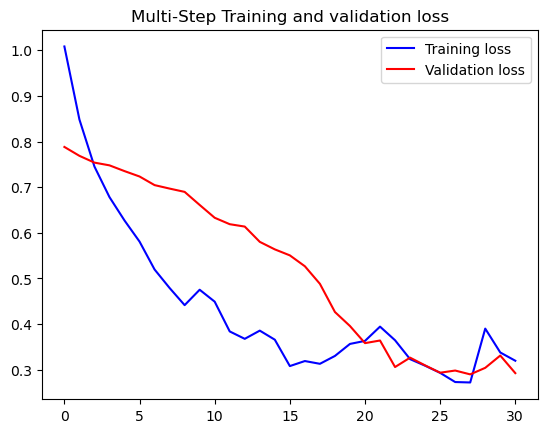

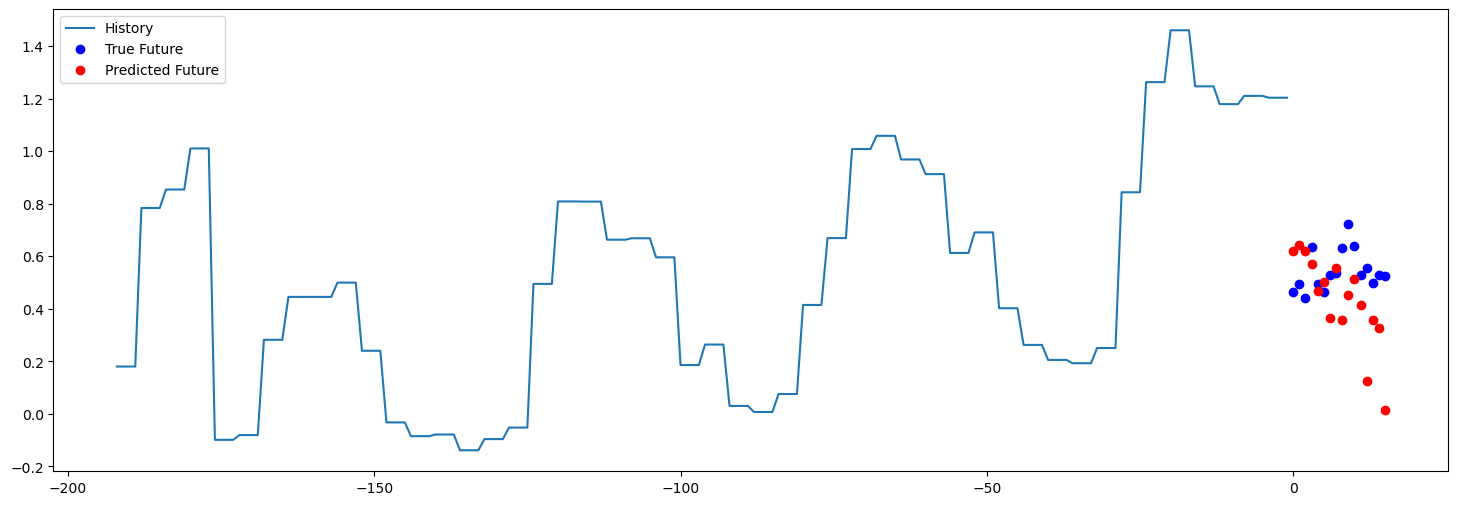

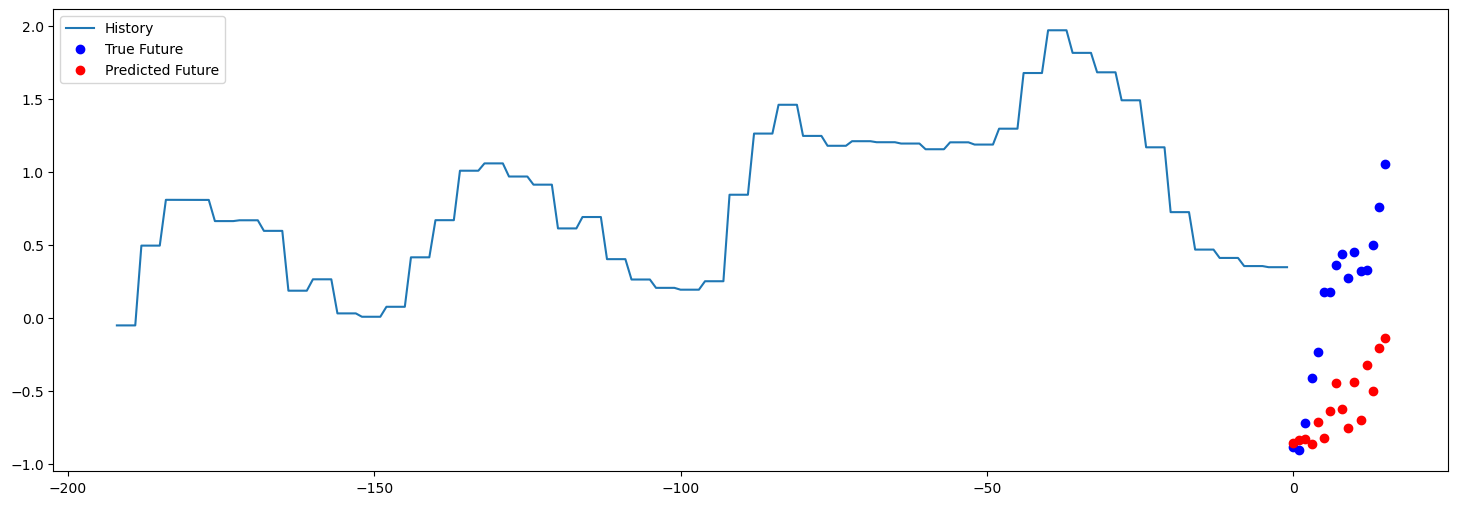

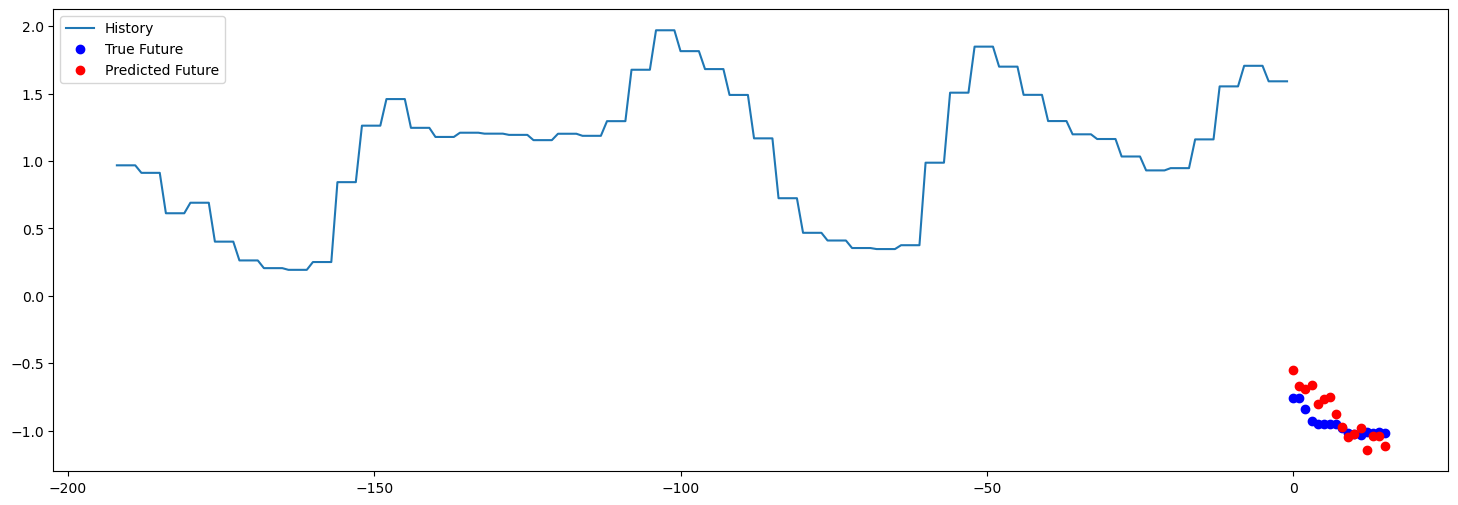

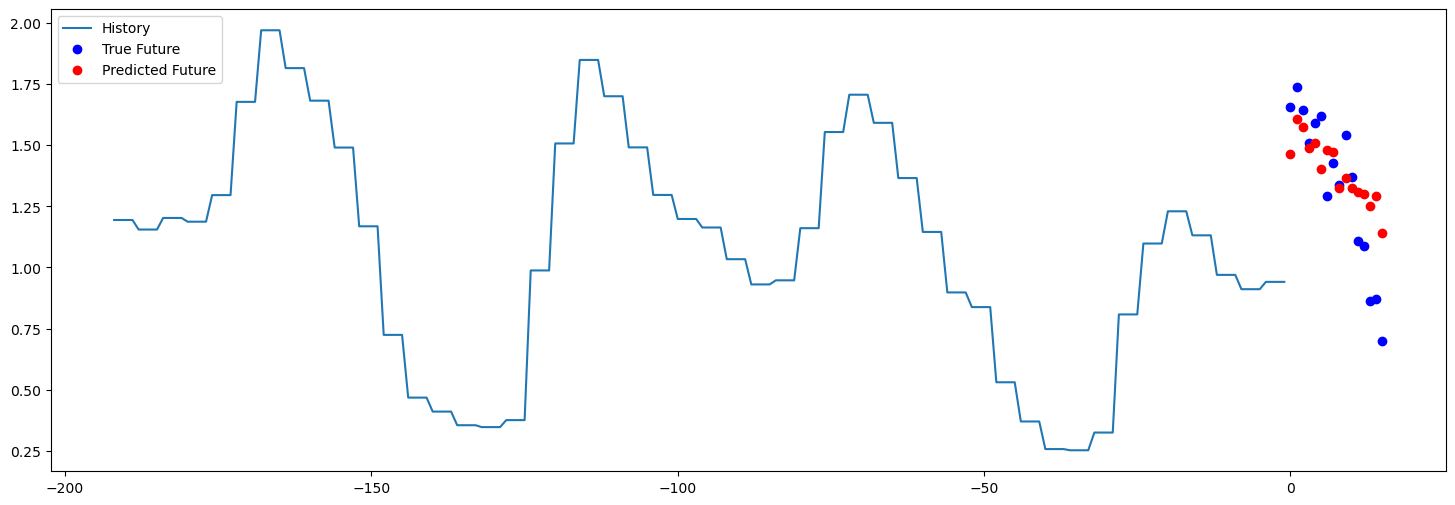

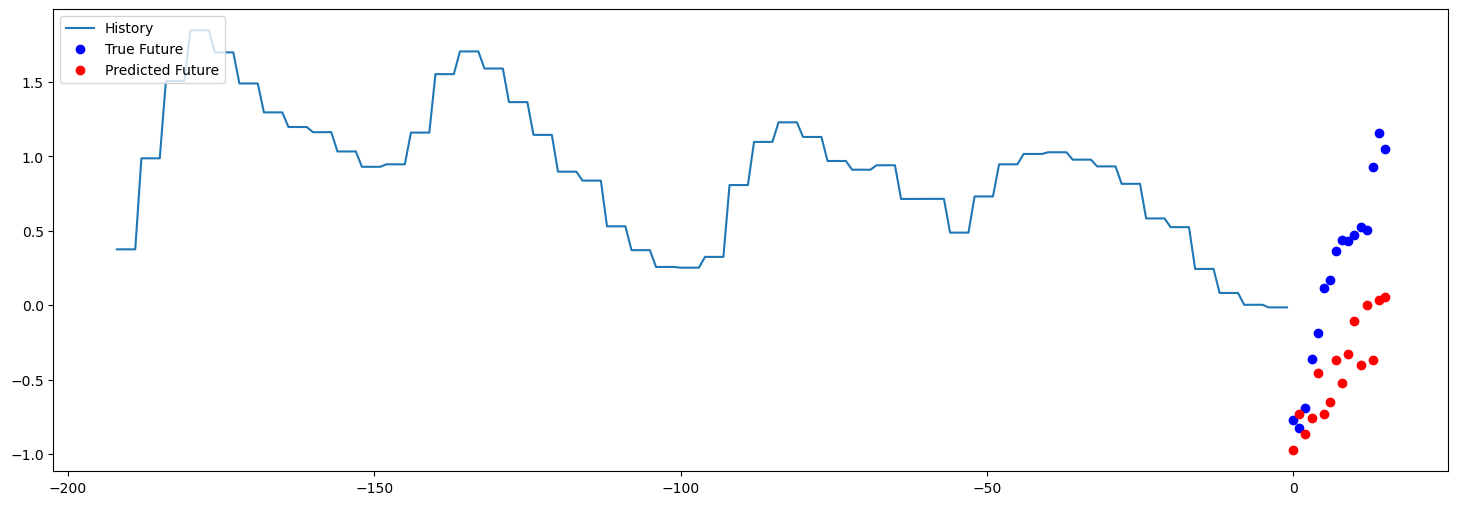

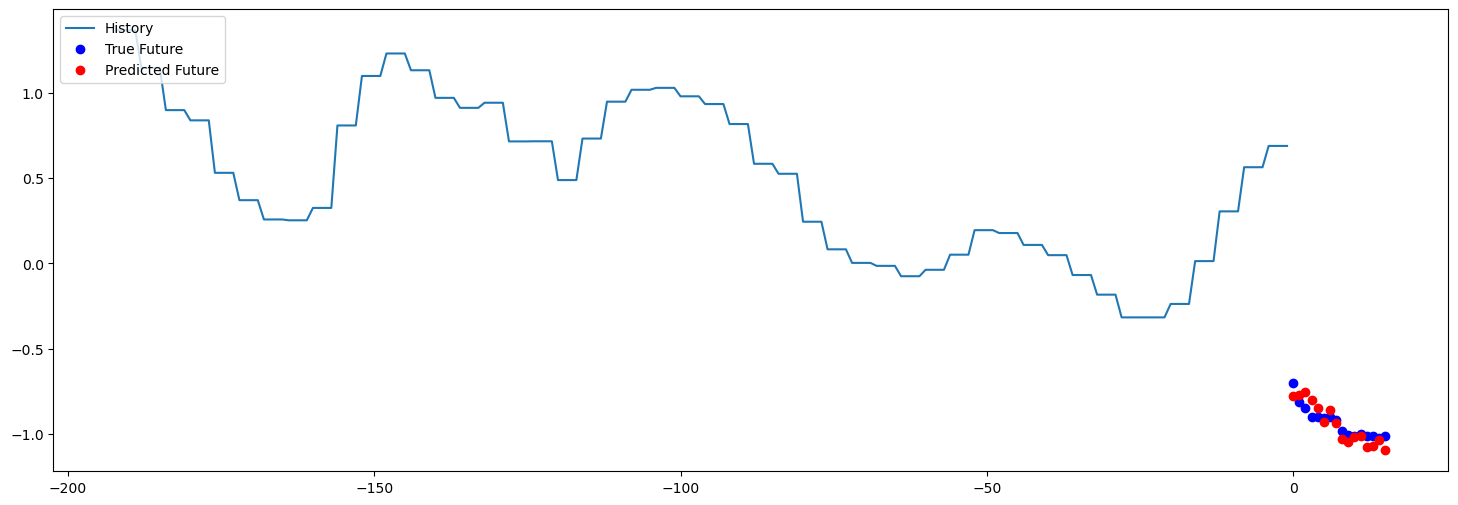

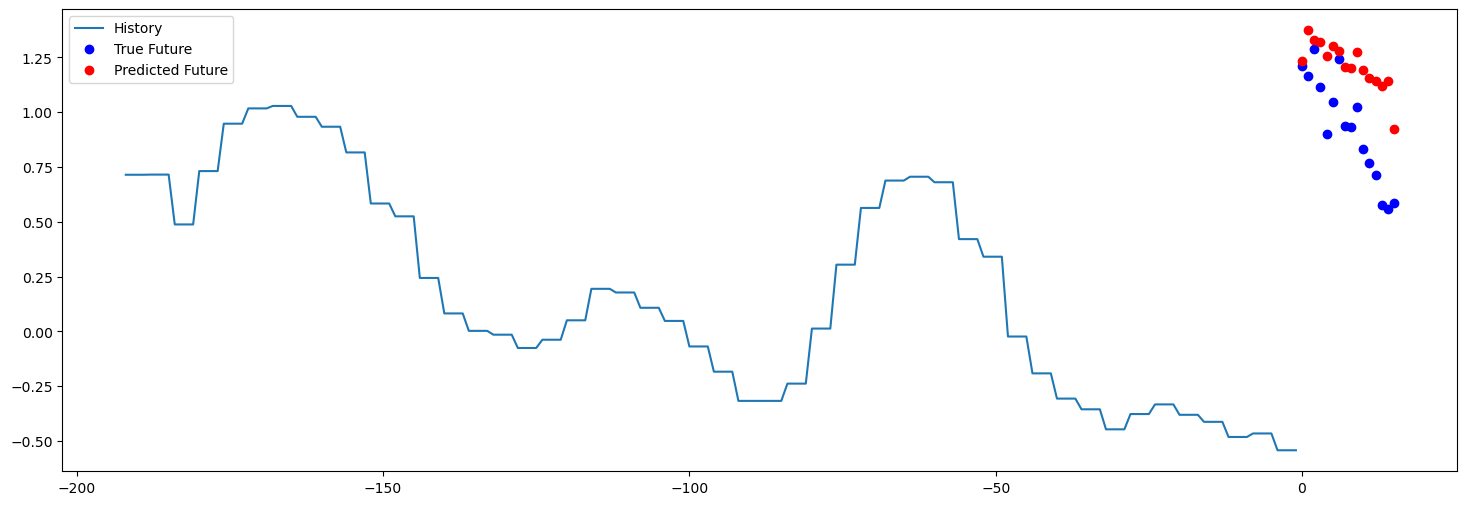

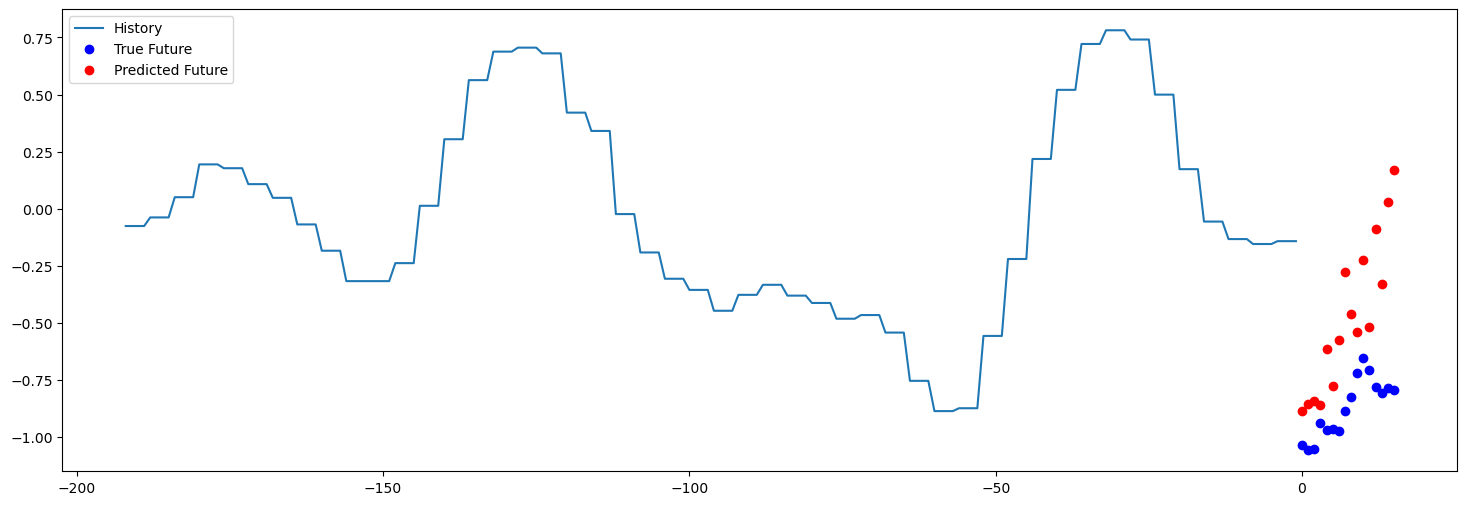

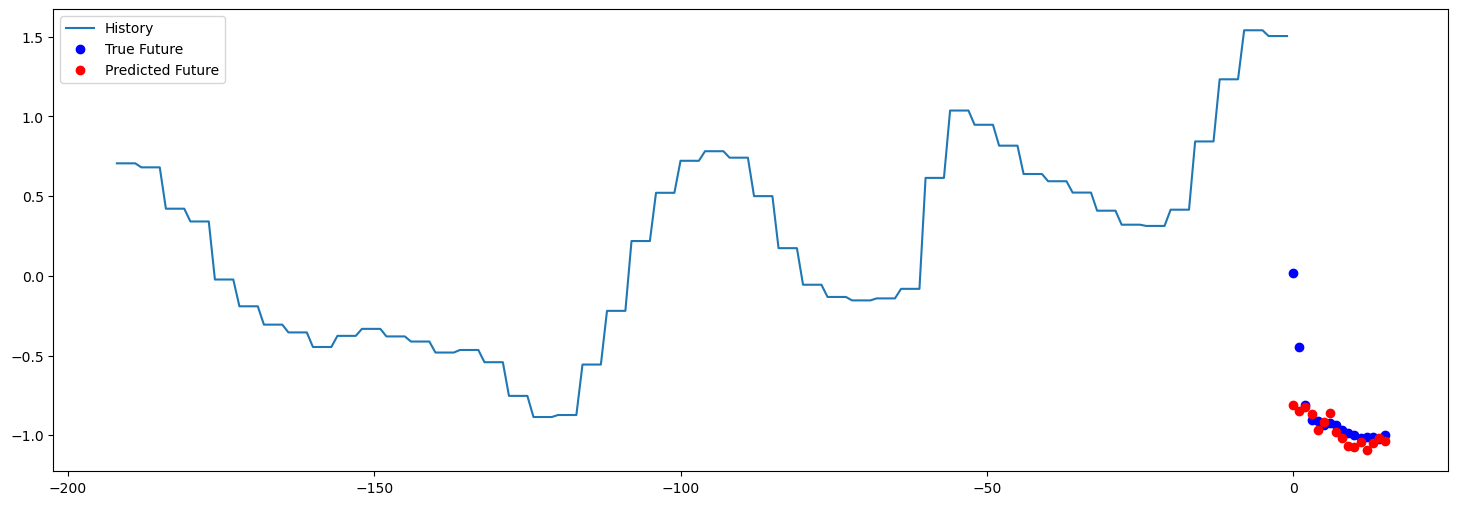

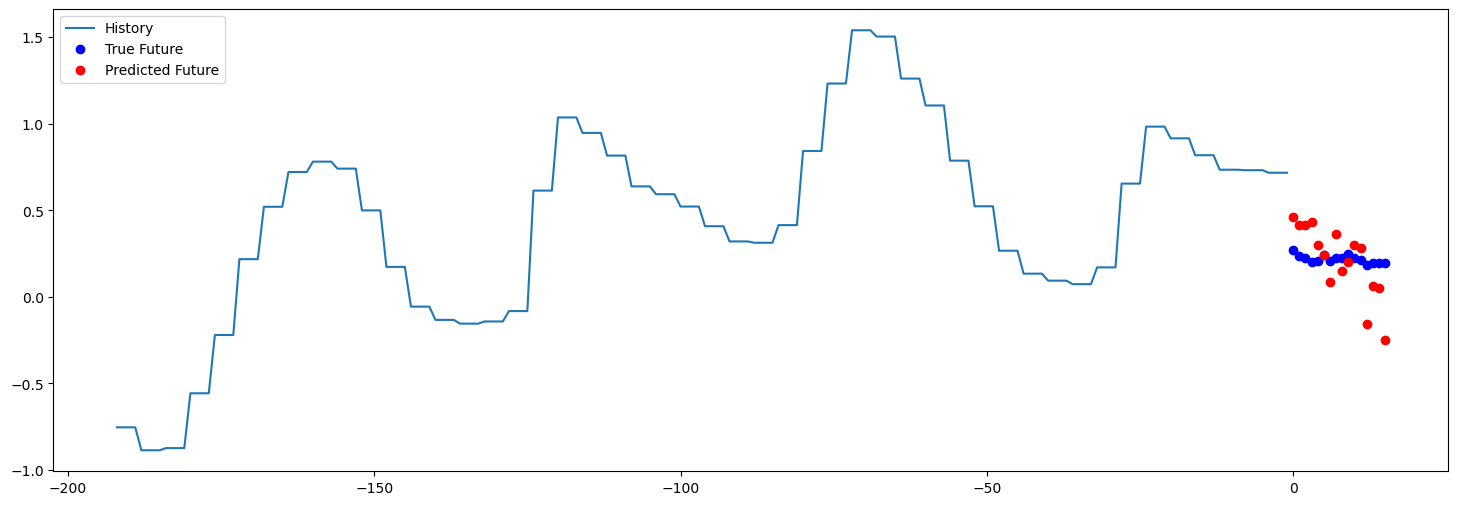

In [6]:
validation_plots(history,10,val_data,model,STEP)